In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # nopep8
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = '1'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
FILE_PATH = os.getcwd()
import sys
sys.path.append('\\'.join(FILE_PATH.split('\\')[:3]))
import pandas as pd
from matplotlib import pyplot as plt
from trainvaltest import trainvaltest

Amount of labels -> 101 

CricketShot has the most samples with 167 clips
PlayingViolin has the least samples with 100 clips

All actions have: 25 samples

Top 5 actions with least clips per sample:
                Total Clips  Samples  Clips per sample
Labels                                               
PlayingViolin          100       25              4.00
PullUps                100       25              4.00
Skijet                 100       25              4.00
TaiChi                 100       25              4.00
BreastStroke           101       25              4.04 

Top 5 actions with most clips per sample
               Total Clips  Samples  Clips per sample
Labels                                              
CricketShot           167       25              6.68
TennisSwing           166       25              6.64
HorseRiding           164       25              6.56
PlayingCello          164       25              6.56
PlayingDhol           164       25              6.56

train/

In [2]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

MODEL_NAME = "the_first_war.h5"
MODEL_PATH = os.path.join(FILE_PATH, MODEL_NAME)
BATCH_SIZE = 16
LABELS, INPUT_SHAPE, Train_Data, Val_Data, Test_Data = trainvaltest(BATCH_SIZE=BATCH_SIZE)
EPOCHS = 20
VERBOSE = 1


Train:
Found 376524 images belonging to 101 classes.
Validation:
Found 37609 images belonging to 101 classes.
Test:
Found 137772 images belonging to 101 classes.

Input shape -> (224, 224, 3)



In [3]:
class Preprocess(layers.Layer):
    def __init__(self, factor=0.2, scale=1.0 / 255.0, flipmode='horizontal', seed=182):
        """Image preprocessing layer Block

        Args:
            factor (float, optional): factor to set for rotation, brightness, zoom and image shifting. Defaults to 0.2.
            scale (float, optional): float to multiple all features by and normalize tensorflow. Defaults to 1.0/255.0.
            seed (int, optional): set the seed value for all preprocessing layers. Defaults to 182
        """
        super(Preprocess, self).__init__()
        self.factor = factor
        self.scale = scale
        self.seed = seed
        self.flipmode = flipmode

        self.rescale = preprocessing.Rescaling(scale=self.scale)
        self.randomrotate = preprocessing.RandomRotation(factor=self.factor, seed=self.seed)
        self.randomzoom = preprocessing.RandomZoom(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.shift = preprocessing.RandomTranslation(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.flip = preprocessing.RandomFlip(mode=self.flipmode, seed=self.seed)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'facotr': self.factor,
            'scale': self.scale,
            'seed': self.seed,
            'flipmode': self.flipmode
        })
        return config    
    
    @tf.function
    def call(self, image):
        """apply all preprocessing steps in

        Args:
            image (tensor): numerical data of image

        Returns:
            tensor: preprocessed data
        """
        image = self.rescale(image)
        image = self.randomrotate(image)
        image = self.randomzoom(image)
        image = self.shift(image)
        image = self.flip(image)
        return image

In [4]:
def conv_layer(filters, kernel_size, padding, strides):
    """Creates a convolution layer for CNNBlock

    Args:
        filters (int): number of filters in conv layer
        kernel_size (int): kernel size for conv layer
        padding (str): either 'same' padding or 'valid' padding
        strides (int): strides for conv layer

    Returns:
        conv layer: returns configured conv layer for CNNBlock
    """
    layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, activation=layers.ReLU())
    return layer

In [5]:
class CNNBlock(layers.Layer):
    def __init__(self, filters, triple=False, conv_kernel_size=(3, 3), conv_strides=(1, 1), pool_size=(2, 2), pool_strides=(2, 2), padding='same'):
        """block of either double (or triple) conv layers

        Args:
            filters (int): numbers of filters for the conv layers within this block
            triple (bool, optional): whether this conv block contains double (2) or triple (3) conv layers. Defaults to False.
            conv_strides (tuple, optional): tuple to set strides value for conv layers. Defaults to (1, 1).
            conv_kernel_size (tuple, optional): kernel size for the conv layers in this block. Defaults to (3, 3).
            pool_size (tuple, optional): pool size for pooling layer for this block. Defaults to (2, 2).
            pool_strides (tuple, optional): strides value for pooling for this block. Defaults to (2, 2).
            padding (str, optional): padding value of conv layers. Defaults to 'same'.
        """
        super(CNNBlock, self).__init__()
        self.triple = triple
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        self.filters = filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_strides = conv_strides
        self.padding = padding

        self.conv1 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.conv2 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        if self.triple == True:
            self.conv3 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.bn = layers.BatchNormalization()
        self.avgpooling = layers.AveragePooling2D(pool_size=self.pool_size, strides=self.pool_strides)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'triple': self.triple,
            'pool_size': self.pool_size,
            'pool_strides': self.pool_strides,
            'filters': self.filters,
            'conv_kernel_size': self.conv_kernel_size,
            'conv_strides': self.conv_strides,
            'padding': self.padding
        })
        return config

    def __call__(self, input_tensor, training=False):
        """forward propagation

        Args:
            input_tensor (input_tensor): input tensor for this data point
            training (bool): whether to set batch normalization to training or not

        Returns:
            tensor: output of the current CNN block
        """
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.triple == True:
            x = self.conv3(x)
        x = self.bn(x, training=training)
        x = self.avgpooling(x)
        return x

In [6]:
class Model(keras.Model):
    def __init__(self, n_labels):
        """model build via subclassing

        Args:
            n_labels (int): amount of labels for the model to predict
        """
        super(Model, self).__init__()
        self.n_labels = n_labels

        self.preprocess = Preprocess()
        self.cnnblock0 = CNNBlock(filters=64)
        self.cnnblock1 = CNNBlock(filters=64)
        self.cnnblock2 = CNNBlock(filters=128)
        self.cnnblock3 = CNNBlock(filters=256, triple=True)
        self.cnnblock4 = CNNBlock(filters=512, triple=True)
        self.cnnblock5 = CNNBlock(filters=512, triple=True)
        self.globalmaxpooling = layers.GlobalMaxPooling2D()
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(0.1)
        self.fc = layers.Dense(2048, activation=layers.ReLU())
        self.dropout2 = layers.Dropout(0.1)
        self.fc2 = layers.Dense(1024, activation=layers.ReLU())
        self.outputs = layers.Dense(self.n_labels)

    @tf.function
    def call(self, input_tensor):
        """forward propagation for the entire model between each layer

        Args:
            input_tensor (tensor): output of the previous layer

        Returns:
            tensor: output of the previous tensor
        """
        x = self.preprocess(input_tensor)
        x = self.cnnblock0(x)
        x = self.cnnblock1(x)
        x = self.cnnblock2(x)
        x = self.cnnblock3(x)
        x = self.cnnblock4(x)
        x = self.cnnblock5(x)
        x = self.globalmaxpooling(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.outputs(x)
        return x

In [7]:
def create_model(inp_shape, n_labels, model_name):
    """creates model (input and output), name layers and compile

    Args:
        inp_shape (tuple(int)): tuple of ints, input shape
        n_labels (int): number of labels for last layer
        model_name (str): name of model
        layer_names (list(str)): list of names for each layer in model

    Returns:
        model: named and configured model with input/output and named layers
    """
    model = keras.Sequential(Model(n_labels=n_labels).layers)    
    model._name = model_name
    model.build(input_shape=(None, *inp_shape))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

    model.summary()
    return model

In [8]:
model = create_model(inp_shape=INPUT_SHAPE, n_labels=LABELS, model_name=MODEL_NAME)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=VERBOSE)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                  monitor='val_acc',
                                                  save_best_only=True,
                                                  save_freq='epoch',
                                                  verbose=VERBOSE)
callbacks = [earlystopping, best_checkpoint]

Model: "the_first_war.h5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Preprocess)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64) 

In [9]:
train = model.fit(Train_Data,
                  epochs=EPOCHS,
                  verbose=VERBOSE,
                  steps_per_epoch=len(Train_Data) // BATCH_SIZE,
                  callbacks=callbacks,
                  validation_data=Val_Data,
                  validation_steps=len(Val_Data) // BATCH_SIZE,
                  use_multiprocessing=True,
                  workers=-1)

Epoch 1/20
1470/1470 [==============================] - 1246s 841ms/step - loss: 3.7594 - acc: 0.1374 - val_loss: 3.6680 - val_acc: 0.1622

Epoch 00001: val_acc improved from -inf to 0.16224, saving model to D:\Python\Action Recognition\the_first_war.h5
Epoch 2/20
1470/1470 [==============================] - 1342s 912ms/step - loss: 3.1070 - acc: 0.2399 - val_loss: 2.9150 - val_acc: 0.2992

Epoch 00002: val_acc improved from 0.16224 to 0.29923, saving model to D:\Python\Action Recognition\the_first_war.h5
Epoch 3/20
1470/1470 [==============================] - 1305s 887ms/step - loss: 2.6592 - acc: 0.3261 - val_loss: 2.6143 - val_acc: 0.3301

Epoch 00003: val_acc improved from 0.29923 to 0.33005, saving model to D:\Python\Action Recognition\the_first_war.h5
Epoch 4/20
1470/1470 [==============================] - 1281s 871ms/step - loss: 2.2552 - acc: 0.4148 - val_loss: 1.9748 - val_acc: 0.4970

Epoch 00004: val_acc improved from 0.33005 to 0.49700, saving model to D:\Python\Action Reco

In [10]:
test = model.evaluate(Test_Data, steps=len(Test_Data) // BATCH_SIZE, workers=-1, use_multiprocessing=True, verbose=VERBOSE)

538/538 [==============================] - 638s 1s/step - loss: 5.2189 - acc: 0.2469


In [11]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,3.759389,0.137415,3.667988,0.162243
1,3.106953,0.239922,2.915003,0.299229
2,2.659169,0.326063,2.614257,0.330051
3,2.255226,0.414753,1.974832,0.497003
4,1.910087,0.497832,1.633926,0.577483


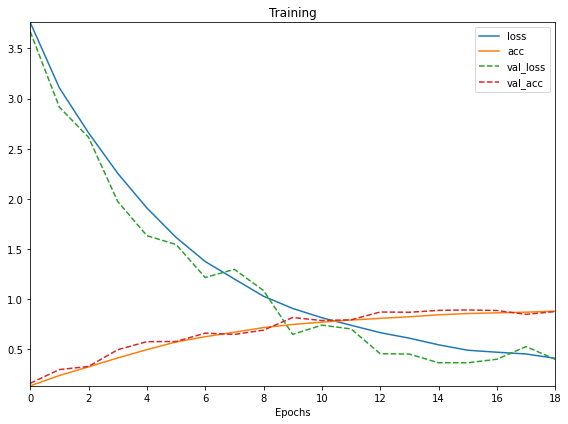

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Training")
def plotline(label):
    return plt.plot(train_history[label], label=label, linestyle='--' if label[:3]=='val' else '-')

for label in train_history.keys():
    plotline(label=label)
plt.xlabel('Epochs')
plt.legend()
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()